$$
\Huge \blue{\textbf{Simple Covariate Shift \qquad}} \\
$$

## Imports & Settings

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

import xgboost as xgb

from src.data_generation import *
from src.analysis import ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts
from src.grid_search import *

np.random.seed(0)

GRID_SEARCH = False
PLOT = False

# 1. Data Creation

In [2]:
DATA_FOLDER = 'data'

# Parameter definition

num_samples = 10000
num_features = 3

# degree of the polinomio for the attribute relationship
degree = 2

## Training Set

In [3]:
# random multivariate

mean_train = [0.90920214, 0.81962487, 0.88819135]

covariance_train = np.array([[0.726318, 0.20240102, 0.52472545],
                             [0.20240102, 0.11392557, 0.0264108],
                             [0.52472545, 0.0264108, 1.05107627]])

# build the features sample
sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
sample_train

array([[-0.61390988,  0.63654601, -0.61594605],
       [-1.4752737 , -0.12556874, -0.58520657],
       [ 0.29459208,  0.72264225, -0.07835173],
       ...,
       [ 0.15576422,  0.53589071, -0.0836271 ],
       [ 0.68755116,  0.7596143 ,  0.14193821],
       [ 1.48600363,  0.94374696,  2.73410303]], shape=(10000, 3))

In [4]:

df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
# random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 
        0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
df_train['Y'] = y_train
df_train['Z'] = z_train

# check for balance
df_train['Y'].value_counts()

Y
1    5495
0    4505
Name: count, dtype: int64

In [5]:

df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
# random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 
        0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
df_train['Y'] = y_train
df_train['Z'] = z_train

# check for balance
df_train['Y'].value_counts()

Y
1    5510
0    4490
Name: count, dtype: int64

In [6]:
df_train.head()

,X1,X2,X3,Y,Z
0,-0.613910,0.636546,-0.615946,1,-1.232201
1,-1.475274,-0.125569,-0.585207,1,0.075931
2,0.294592,0.722642,-0.078352,0,-1.463998
3,0.448019,0.953445,0.595365,1,-0.783403
4,0.273194,0.757800,0.220965,0,-1.163165


## Testing Sets: Shifted Distribution Mixtures

To be as general as possible, we consider statistical mixtures and study the presumed progressive degradation in performance for increasingly pure mixtures towards the test distribution.

In [7]:
# shifted random multivariate
mean_shift = attributes_quantile(df_train, 0.05)

covariance_shift = [[ 0.16309729,  0.19325742, -0.12621892],
                    [ 0.19325742,  0.25197638, -0.13972381],
                    [-0.12621892, -0.13972381,  0.19160666]]

# Initialize an empty dictionary to store the dataframes
df_dict = {}

# Iterate over mix_prob values
for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    # Generate mixture sample
    sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

    # Create a DataFrame for the features
    df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

    # Build the target variable y
    y_mix, z_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
    df_mix['Y'] = y_mix
    df_mix['Z'] = z_mix

    # Store the DataFrame in the dictionary
    df_dict[mix_prob] = df_mix

Remark: the 0.0 is a sample from the distribution that generated the training set. Since `build_mixture_sample` function do the dample each time, the 0.0 sample can be used as test set.

## Saving Data to Files

In [8]:
# Create a folder
folder_name = os.path.join('data')
os.makedirs(folder_name, exist_ok=True)

for mix_prob, df in df_dict.items():
    df.to_csv(os.path.join(folder_name, f'mix_{mix_prob}.csv'), index=False)
file_name = 'Parameters.txt'
file_path = os.path.join(folder_name, file_name)
df_train.to_csv(os.path.join(folder_name, 'train.csv'), index=False)

with open(file_path, 'w') as f:
  f.write('Polinomial coefficients\n')
  f.write(f'{coef_train}\n')
  f.write('Mean train\n')
  f.write(f'{mean_train}\n')
  f.write('Covariance train\n')
  f.write(f'{covariance_train}\n')
  f.write('Mean shift\n')
  f.write(f'{mean_shift}\n')
  f.write('Covariance shift\n')
  f.write(f'{covariance_shift}\n')

 # 2. Data Visualization

## Polinomio

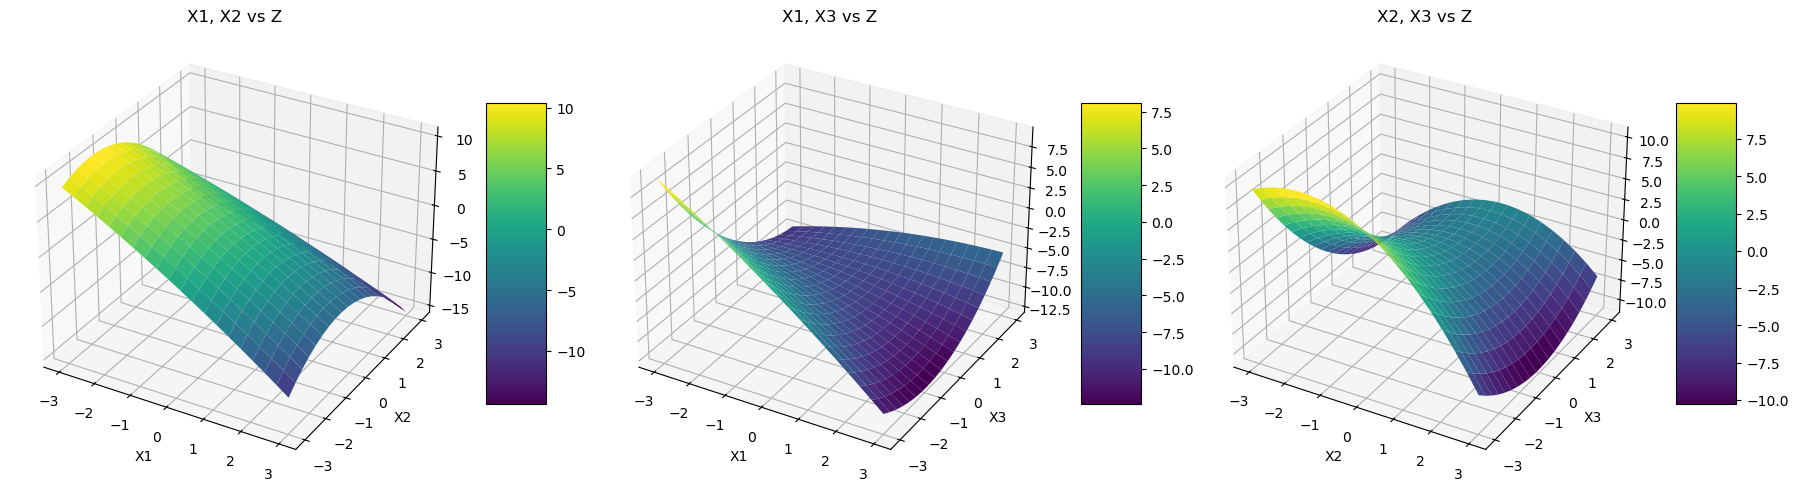

In [9]:
if PLOT:
    # Generate a grid of x1, x2, and x3 values
    x1_arr = np.linspace(-3, 3, 20)  # Reduced the number of points to 20

    x1, x2, x3 = np.meshgrid(x1_arr, x1_arr, x1_arr)

    # Flatten the grid to pass into the polynomial function
    x1_flat = x1.flatten()
    x2_flat = x2.flatten()
    x3_flat = x3.flatten()

    # Create a combined array of x1, x2, and x3 values
    samples = np.column_stack((x1_flat, x2_flat, x3_flat))

    # Calculate the polynomial values for the grid
    _, z_values, _ = build_poly_target(samples, degree, coefficients=coef_train)

    # Reshape the z values back to the grid shape
    z_values = z_values.reshape(x1.shape)

    # Create 3D surface plots for all combinations
    fig = plt.figure(figsize=(18, 12))

    # x1, x2 vs z
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(x1[:, :, 0], x2[:, :, 0], z_values[:, :, 0], cmap=cm.viridis, edgecolor='none')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z')
    ax1.set_title('X1, X2 vs Z')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    # x1, x3 vs z
    ax2 = fig.add_subplot(232, projection='3d')
    surf2 = ax2.plot_surface(x1[0, :, :], x3[0, :, :], z_values[0, :, :], cmap=cm.viridis, edgecolor='none')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X3')
    ax2.set_zlabel('Z')
    ax2.set_title('X1, X3 vs Z')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # x2, x3 vs z
    ax3 = fig.add_subplot(233, projection='3d')
    surf3 = ax3.plot_surface(x2[:, 0, :], x3[:, 0, :], z_values[:, 0, :], cmap=cm.viridis, edgecolor='none')
    ax3.set_xlabel('X2')
    ax3.set_ylabel('X3')
    ax3.set_zlabel('Z')
    ax3.set_title('X2, X3 vs Z')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

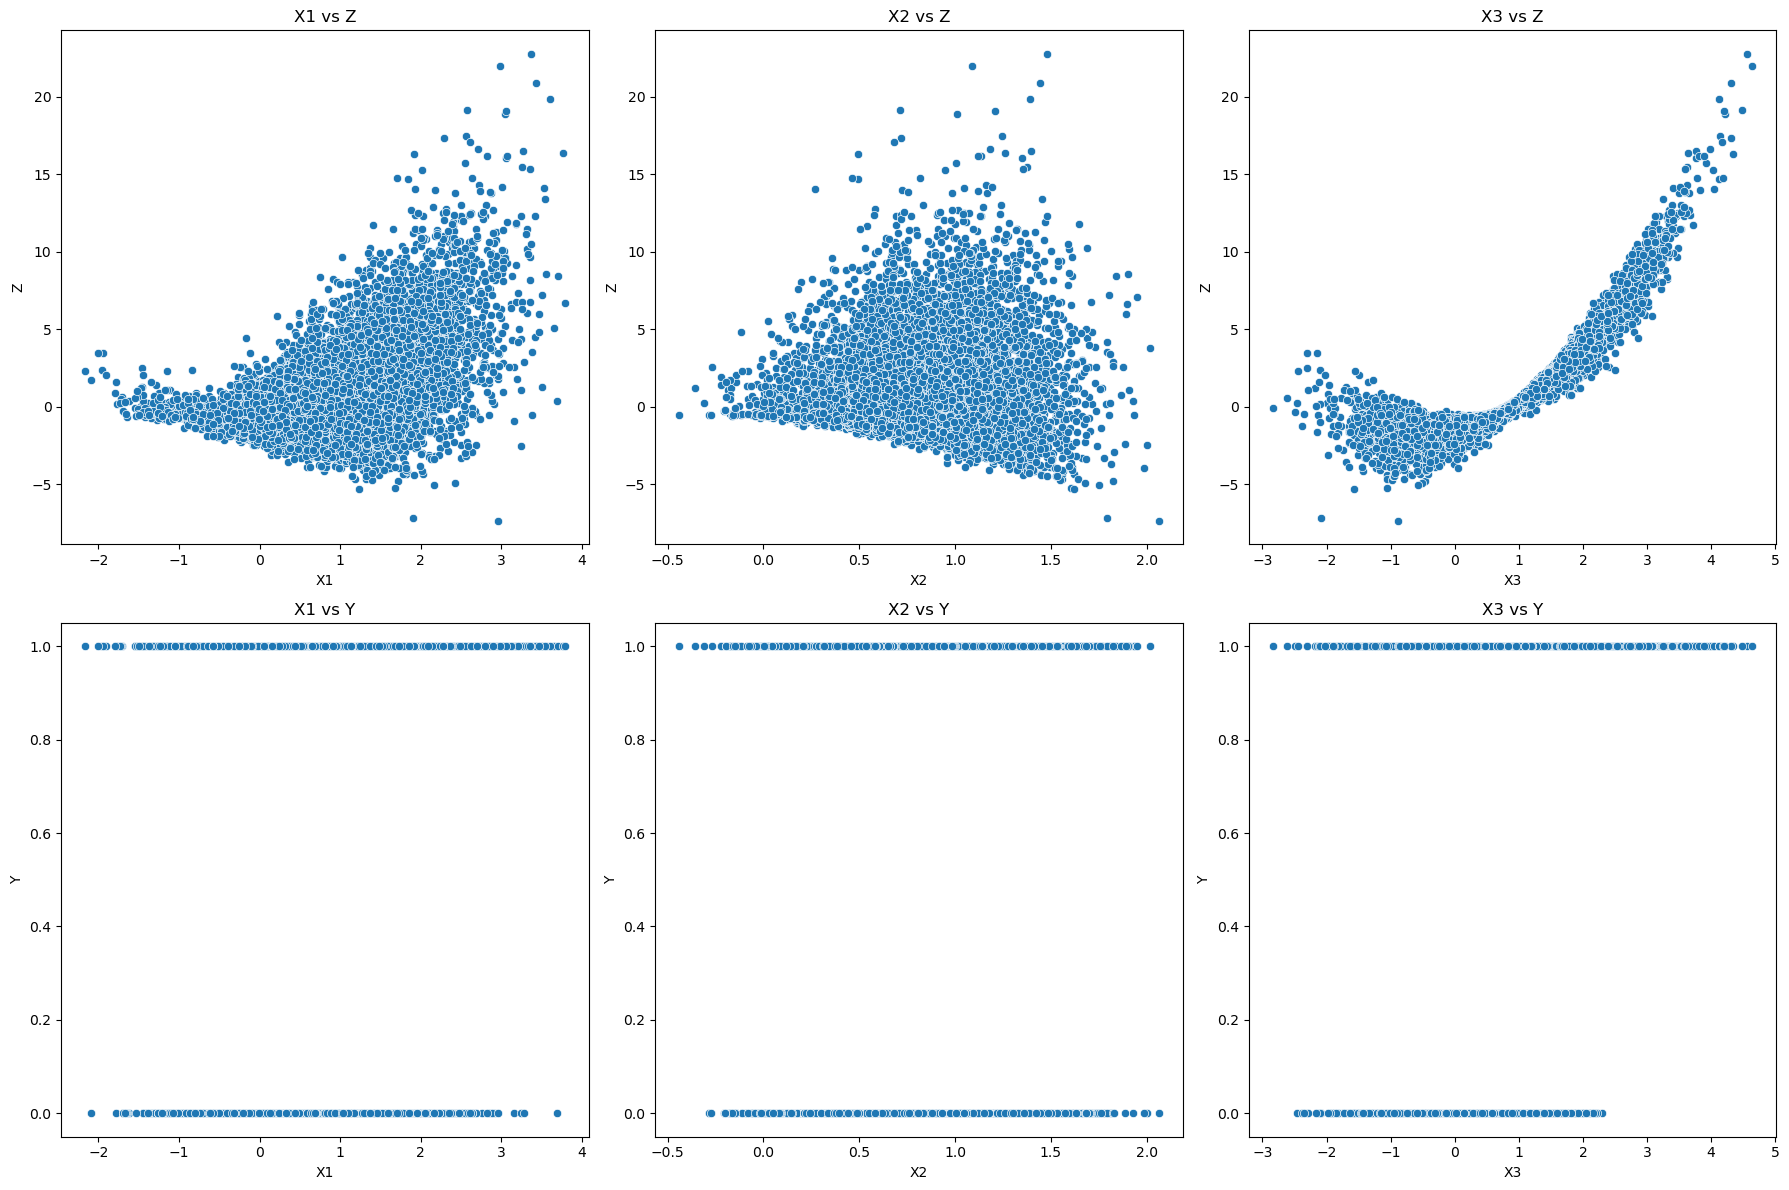

In [ ]:
if PLOT:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot X1 vs Z
    sns.scatterplot(ax=axes[0, 0], x=df_train['X1'], y=z_train)
    axes[0, 0].set_title('X1 vs Z')
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('Z')

    # Plot X2 vs Z
    sns.scatterplot(ax=axes[0, 1], x=df_train['X2'], y=z_train)
    axes[0, 1].set_title('X2 vs Z')
    axes[0, 1].set_xlabel('X2')
    axes[0, 1].set_ylabel('Z')

    # Plot X3 vs Z
    sns.scatterplot(ax=axes[0, 2], x=df_train['X3'], y=z_train)
    axes[0, 2].set_title('X3 vs Z')
    axes[0, 2].set_xlabel('X3')
    axes[0, 2].set_ylabel('Z')

    # Plot X1 vs Y
    sns.scatterplot(ax=axes[1, 0], x=df_train['X1'], y=df_train['Y'])
    axes[1, 0].set_title('X1 vs Y')
    axes[1, 0].set_xlabel('X1')
    axes[1, 0].set_ylabel('Y')

    # Plot X2 vs Y
    sns.scatterplot(ax=axes[1, 1], x=df_train['X2'], y=df_train['Y'])
    axes[1, 1].set_title('X2 vs Y')
    axes[1, 1].set_xlabel('X2')
    axes[1, 1].set_ylabel('Y')

    # Plot X3 vs Y
    sns.scatterplot(ax=axes[1, 2], x=df_train['X3'], y=df_train['Y'])
    axes[1, 2].set_title('X3 vs Y')
    axes[1, 2].set_xlabel('X3')
    axes[1, 2].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

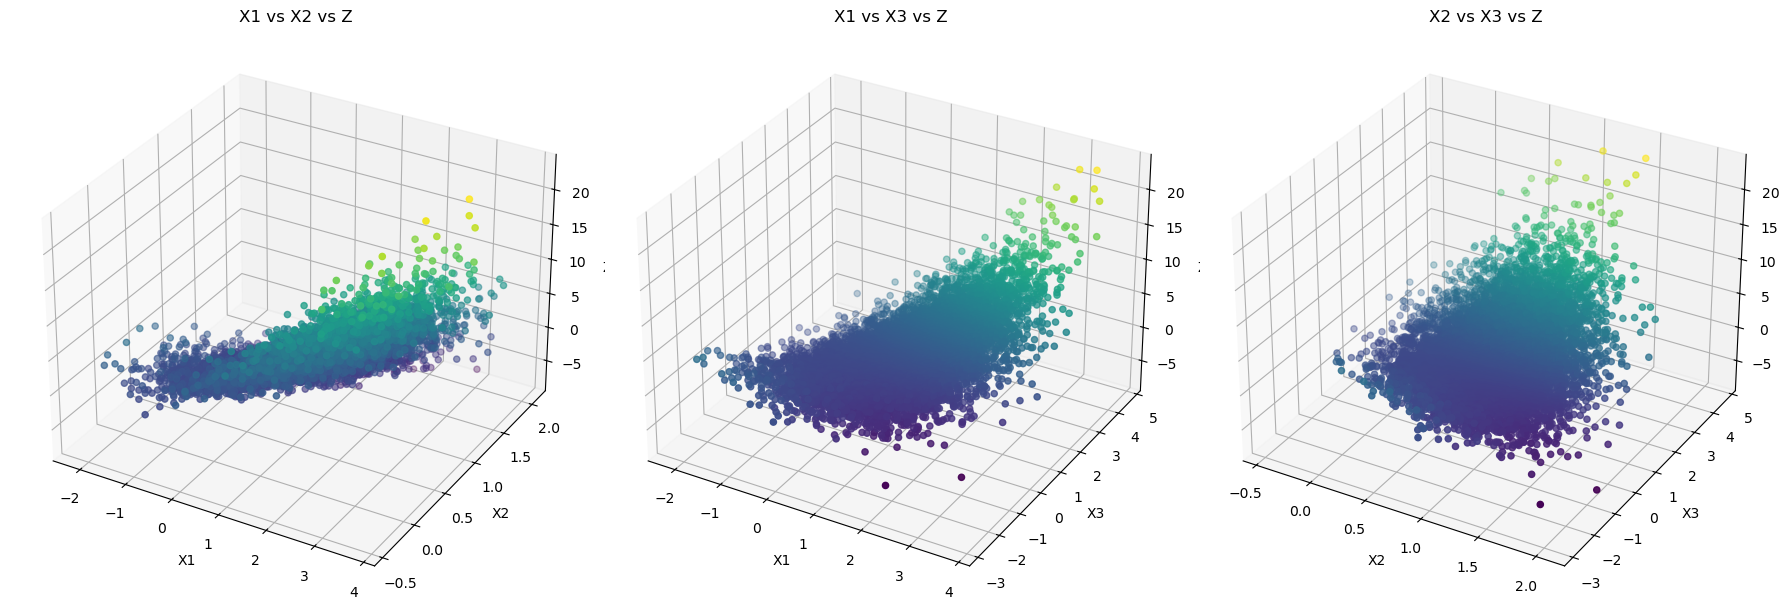

In [ ]:
if PLOT:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(18, 12))

    # Plot X1 vs X2 vs Z
    ax = fig.add_subplot(231, projection='3d')
    ax.scatter(df_train['X1'], df_train['X2'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X1 vs X2 vs Z')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Z')

    # Plot X1 vs X3 vs Z
    ax = fig.add_subplot(232, projection='3d')
    ax.scatter(df_train['X1'], df_train['X3'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X1 vs X3 vs Z')
    ax.set_xlabel('X1')
    ax.set_ylabel('X3')
    ax.set_zlabel('Z')

    # Plot X2 vs X3 vs Z
    ax = fig.add_subplot(233, projection='3d')
    ax.scatter(df_train['X2'], df_train['X3'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X2 vs X3 vs Z')
    ax.set_xlabel('X2')
    ax.set_ylabel('X3')
    ax.set_zlabel('Z')

    plt.tight_layout()
    plt.show()


 For higher dimensional data (n > 2), we can either:

 - Visualize a pairwise scatter matrix (e.g., `sns.pairplot`) for a subset of features.

 - Or just visualize a specified pair of features for a quick glimpse.

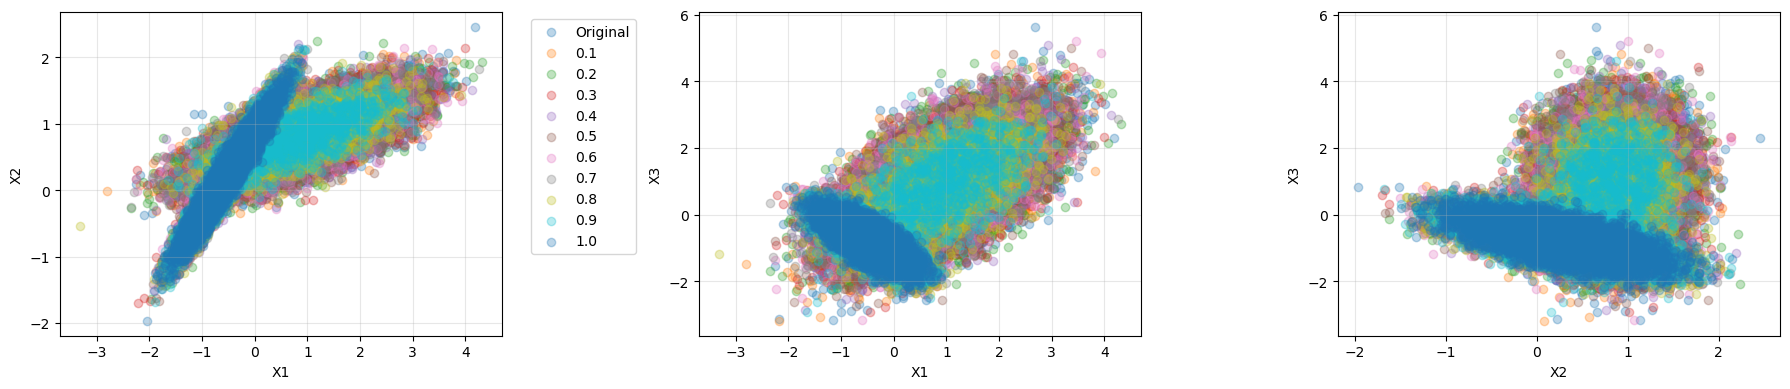

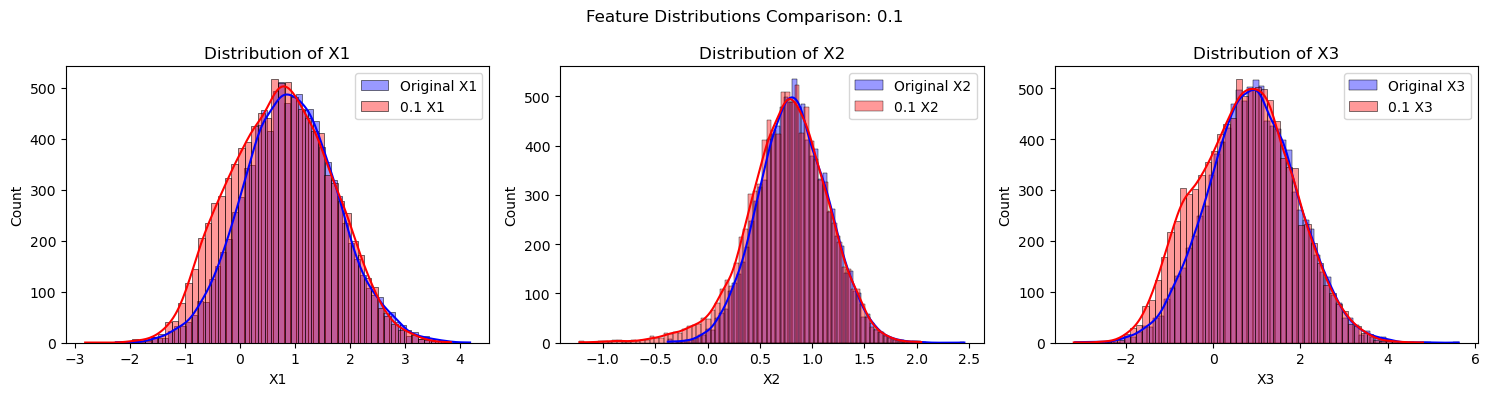

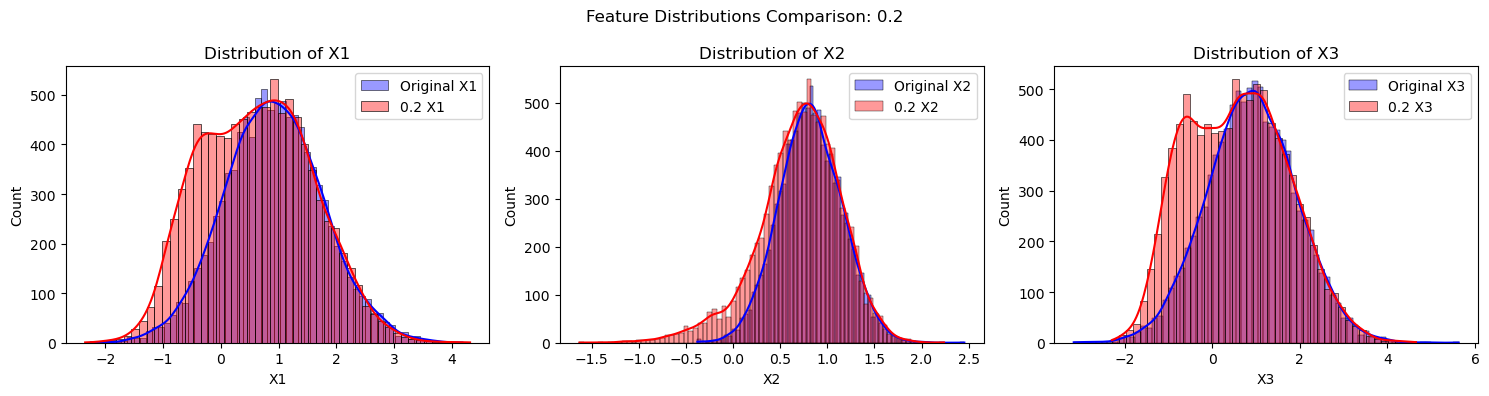

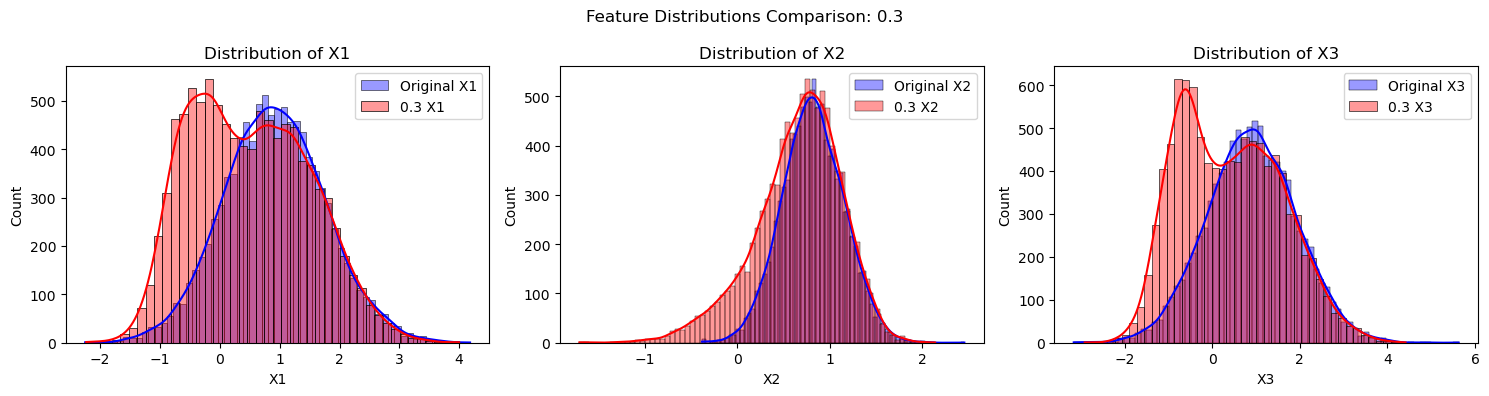

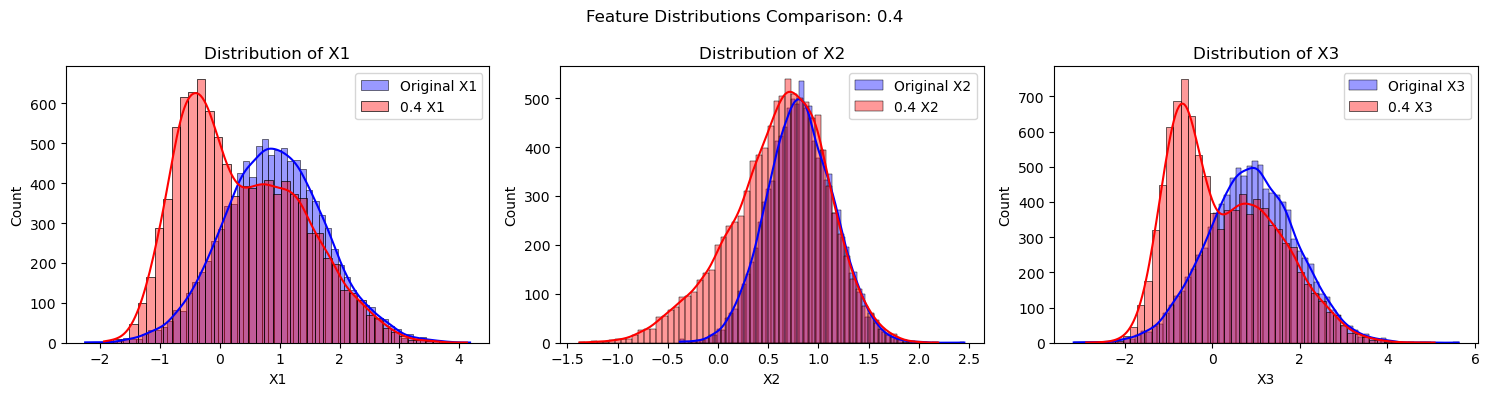

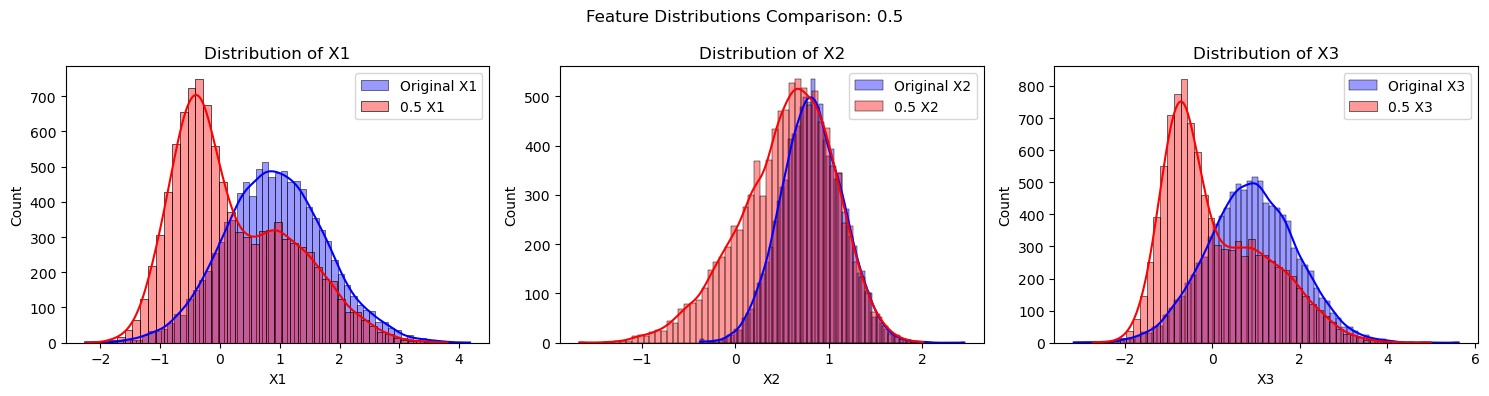

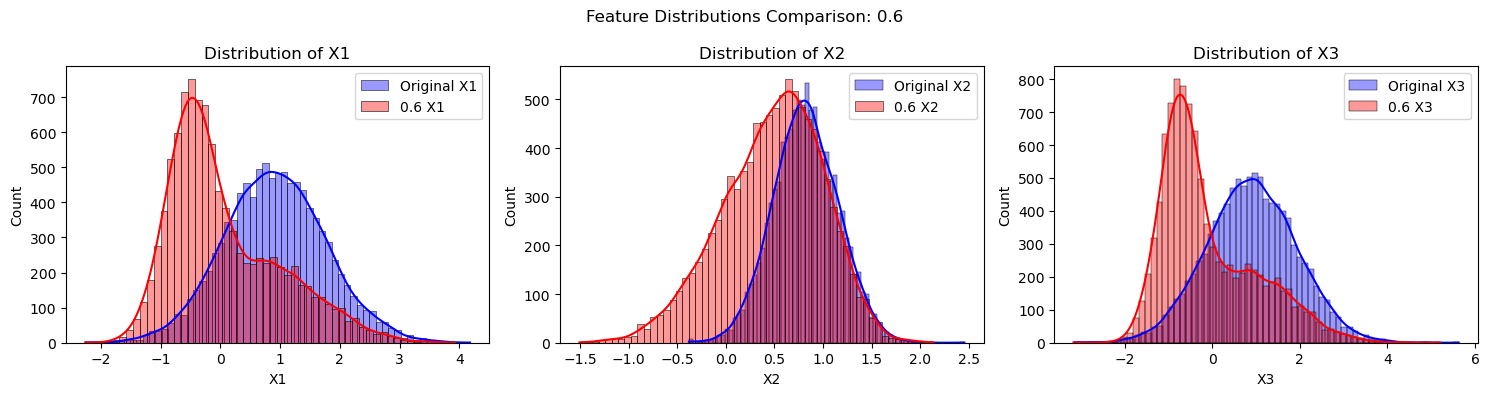

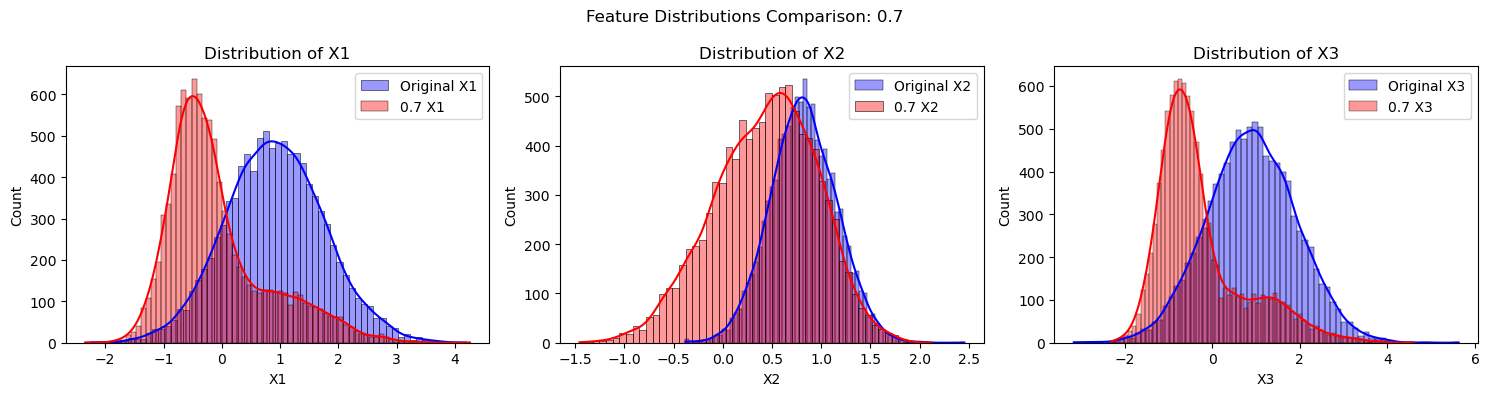

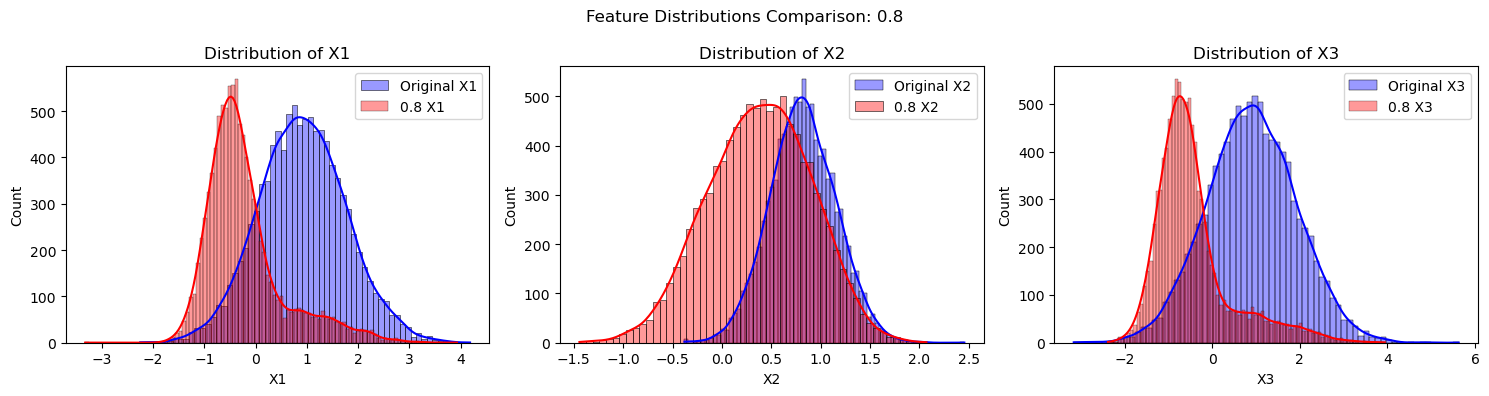

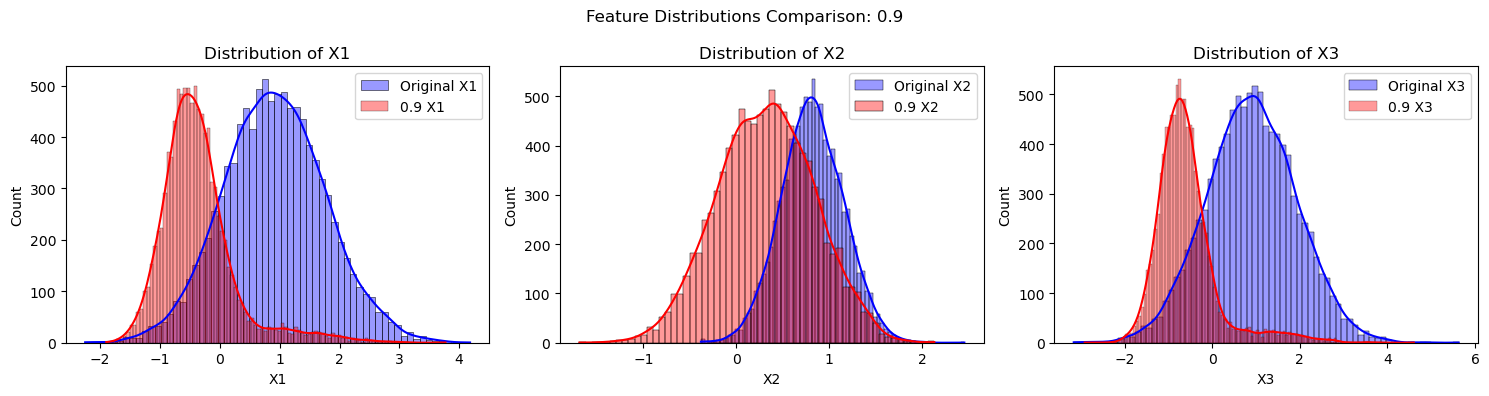

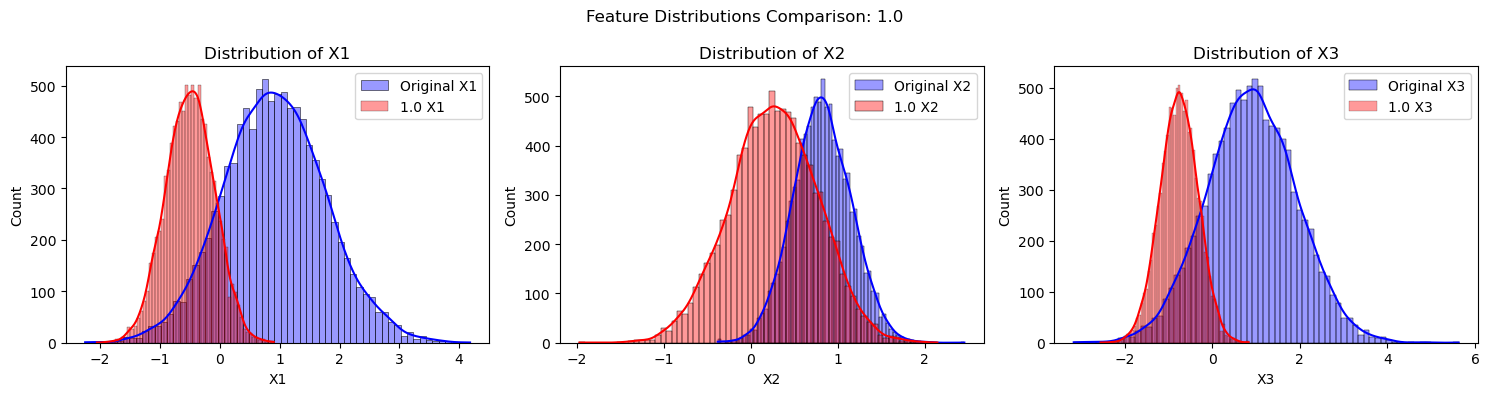

In [ ]:
if PLOT:
    visualize_feature_shifts(df_dict=df_dict, features_to_plot= ['X1', 'X2', 'X3'])

# 3. Models Training

In [13]:
# Load train data

X_train = df_train.drop(['Y','Z'], axis=1)
y_train = df_train['Y']

X_train.head()

,X1,X2,X3
0,-0.613910,0.636546,-0.615946
1,-1.475274,-0.125569,-0.585207
2,0.294592,0.722642,-0.078352
3,0.448019,0.953445,0.595365
4,0.273194,0.757800,0.220965


## Logistic Regression (Baseline)

## GAM Model

In [14]:
lgam_params = {
    "terms": s(0) + s(1) + s(2) + te(0, 1) + te(0, 2) + te(1, 2),
    "max_iter": 100
}

X_train_np = X_train.values  # Convert to NumPy array
y_train_np = y_train.values  # Convert to NumPy array

if GRID_SEARCH:
    lgam_model = LogisticGAM(**lgam_params).gridsearch(X_train_np, y_train_np, lam=np.logspace(-3, 3, 10))
else:
    lgam_model = LogisticGAM(**lgam_params).fit(X_train_np, y_train_np)

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
/usr/lib/python3.13/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/lib/python3.13/site-packages/pygam/pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 10% (1 of 10) |##                       | Elapsed Time: 0:00:57 ETA:   0:08:40
/usr/lib/python3.13/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/lib/python3.13/site-packages/pygam/pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 20% (2 of 10) |#####                    | Elapsed Time: 0:01:20 ETA:   0:05:20
/usr/lib/python3.13/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu 

In [15]:
lgam_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     17.2102
Link Function:                        LogitLink Log Likelihood:                                 -4328.1962
Number of Samples:                        10000 AIC:                                             8690.8128
                                                AICc:                                            8690.8829
                                                UBRE:                                               2.8705
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3708
Feature Function                  Lam

/tmp/ipykernel_182644/689967230.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  lgam_model.summary()


## Decision Tree Classifier

In [ ]:
# Define the parameter grid
dtc_grid = {
    'criterion': ['gini', 'entropy'],#, 'log_loss'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'splitter': ['best', 'random']
}
# dtc_grid = {
#     "max_depth": [  10,12, 13, 14],
#     "min_samples_leaf": [  10,12, 14, 16],
#     "criterion" : ['gini', 'entropy'],
#     "splitter" : ['random', 'best']
# }

if GRID_SEARCH:
    dtc_model = grid_search_cv(DecisionTreeClassifier(), dtc_grid, X_train, y_train, cv = None)
else:
    dtc_model = DecisionTreeClassifier(**best_params["DecisionTreeClassifier"])
    dtc_model.fit(X_train, y_train)

## Random Forest

### Fine-tuning

In [ ]:
# Define the parameter grid for Random Forest
rf_grid = {
    'n_estimators': [75, 100, 125],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1,2],
    'max_samples': [0.5, 0.6, 0.7, 0.8],
    'random_state': [0]
}
# rf_grid = {
#     'criterion' : ['gini', 'entropy'],
#     'n_estimators': [150, 175, 200],
#     'max_depth': [7, 9, 10, 12],
#     'min_samples_split': [10,11,12, 14],
#     'min_samples_leaf': [ 2,4,6],
#     'random_state': [0]
# }

if GRID_SEARCH:
    rfc_model = grid_search_cv(RandomForestClassifier(), rf_grid, X_train, y_train, cv = None)
else:
    rfc_model = RandomForestClassifier(**best_params["RandomForestClassifier"])
    rfc_model.fit(X_train, y_train)

## Gradient Boosting

### Fine-tuning

In [ ]:
# Define the parameter grid for Gradient Boosting
gbc_grid = {
        'n_estimators': [75, 100, 125],
        'learning_rate': [0.01, 0.0075, 0.005],
        'max_depth': [3, 4, 5],
        'min_samples_leaf': [6, 8, 10],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': [None]#, 'sqrt', 'log2']
    }
# gbc_grid = {
#     'n_estimators': [115, 125, 150, 165],
#     'learning_rate': [0.0005, 0.025, 0.0125],
#     'max_depth': [3, 6, 8],
#     'subsample': [0.4, 0.5, 0.6, 0.7],
#     'max_features': [None]#, 'sqrt', 'log2']
# }

if GRID_SEARCH:
    gbc_model = grid_search_cv(GradientBoostingClassifier(), gbc_grid, X_train, y_train)
else:
    gbc_model = GradientBoostingClassifier(**best_params["GradientBoostingClassifier"])
    gbc_model.fit(X_train, y_train)

## Extreme Gradient Boosting

In [19]:
import xgboost as xgb

# #XGBoost Parameters
# xgb_params = {
#     "learning_rate":0.025,
#     "max_depth": 5,
#     "n_estimators": 100,
#     "subsample":0.7
# }

xgb_model = xgb.XGBClassifier(**best_params["GradientBoostingClassifier"]).fit(X_train, y_train)

## Overfit Decision Tree

In [20]:
# dtc_grid = {
#     "max_depth": [  10,12, 13, 14,16],
#     "min_samples_leaf": [  10,12, 14, 16],
#     "criterion" : ['gini', 'entropy'],
#     "splitter" : ['random', 'best']
# }

# dtc_model = DecisionTreeClassifier()

# best_dtc_model, best_dtc_params, best_dtc_score = overfit_models(X_train, y_train, dtc_model, dtc_grid)
# #{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 10, 'splitter': 'best'}


## Overfit Random Forest

In [21]:
# rfc_grid = {
#     'criterion' : ['gini', 'entropy'],
#     'n_estimators': [150, 175, 200],
#     'max_depth': [ 7, 9, 10, 12],
#     'min_samples_split': [10,11,12, 14],
#     'min_samples_leaf': [ 2,4,6],
#     'random_state': [0]
# }

# rfc_model = RandomForestClassifier()

# best_rfc_model, best_rfc_params, best_rfc_score = overfit_models(X_train, y_train, rfc_model, rfc_grid)
# #{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 175, 'random_state': 0}

## Overfit Gradient Boosting


In [22]:
# gbc_grid = {
#     'n_estimators': [ 125, 150, 165, 185],
#     'learning_rate': [0.03, 0.025, 0.0175],
#     'max_depth': [ 6, 8, 10, 11],
#     'subsample': [0.5, 0.6, 0.7],
#     'max_features': [None]#, 'sqrt', 'log2']
# }

# gbc_model = GradientBoostingClassifier()
# best_gbc_model, best_gbc_params, best_gbc_score = overfit_models(X_train, y_train, gbc_model, gbc_grid)
# #{'learning_rate': 0.025, 'max_depth': 8, 'max_features': None, 'n_estimators': 165, 'subsample': 0.7}

## Overfit XGBoost

In [23]:
# xgb_grid = {
#     'n_estimators': [150, 175, 200],
#     'learning_rate': [0.03, 0.025, 0.0175],
#     'max_depth': [8, 10, 12, 0],
#     'subsample': [0.5, 0.6, 0.7],
# }

# xgb_model = xgb.XGBClassifier()
# best_xgb_model, best_xgb_params, best_xgb_score = overfit_models(X_train, y_train, xgb_model, xgb_grid)
##{'learning_rate': 0.03, 'max_depth': 0, 'n_estimators': 200, 'subsample': 0.7}

In [24]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.utils._tags import _safe_tags

# class XGBClassifierWrapper(xgb.XGBClassifier, BaseEstimator, ClassifierMixin):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
    
#     # Definiamo direttamente sklearn_tags per fornire i tag necessari
#     def sklearn_tags(self):
#         # Ricaviamo i tag di base che scikit-learn si aspetterebbe 
#         # da un "normale" XGBClassifier
#         parent_tags = _safe_tags(xgb.XGBClassifier())
        
#         # Sovrascriviamo (o aggiungiamo) i tag che ci servono
#         parent_tags["estimator_type"] = "classifier"
        
#         return parent_tags


# # Definisci la griglia dei parametri
# param_grid_xgb = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01],
#     'n_estimators': [100, 200],
#     'subsample': [0.8, 1.0],
#     'min_child_weight': [1, 3]
# }

# # Inizializza il modello base con il wrapper
# xgb_base = XGBClassifierWrapper(
#     objective='binary:logistic',
#     random_state=42,
#     tree_method='hist',
#     eval_metric='auc'
# )

# # Configura GridSearchCV
# grid_search_xgb = GridSearchCV(
#     estimator=xgb_base,
#     param_grid=param_grid_xgb,
#     cv=5,
#     scoring='roc_auc',
#     n_jobs=-1,
#     verbose=1
# )

# # Esegui la Grid Search (presupponendo che X_train e y_train siano già definiti)
# grid_search_xgb.fit(X_train, y_train)

# # Ottieni i migliori parametri e il miglior modello
# best_params_xgb = grid_search_xgb.best_params_
# print(f"Best parameters found: {best_params_xgb}")

# xgb_model = grid_search_xgb.best_estimator_

 # 4. Model Evaluation After the Shift

In [25]:
# Define the models to evaluate

models = {
    "DecisionTreeClassifier" : dtc_model,      # dtc_model
    "GradientBoostingClassifier" : gbc_model,  # gbc_model
    "RandomForestClassifier" : rfc_model,      # rfc_model 
    "XGBoost" : xgb_model,
    "LogisticGAM" : lgam_model
    }

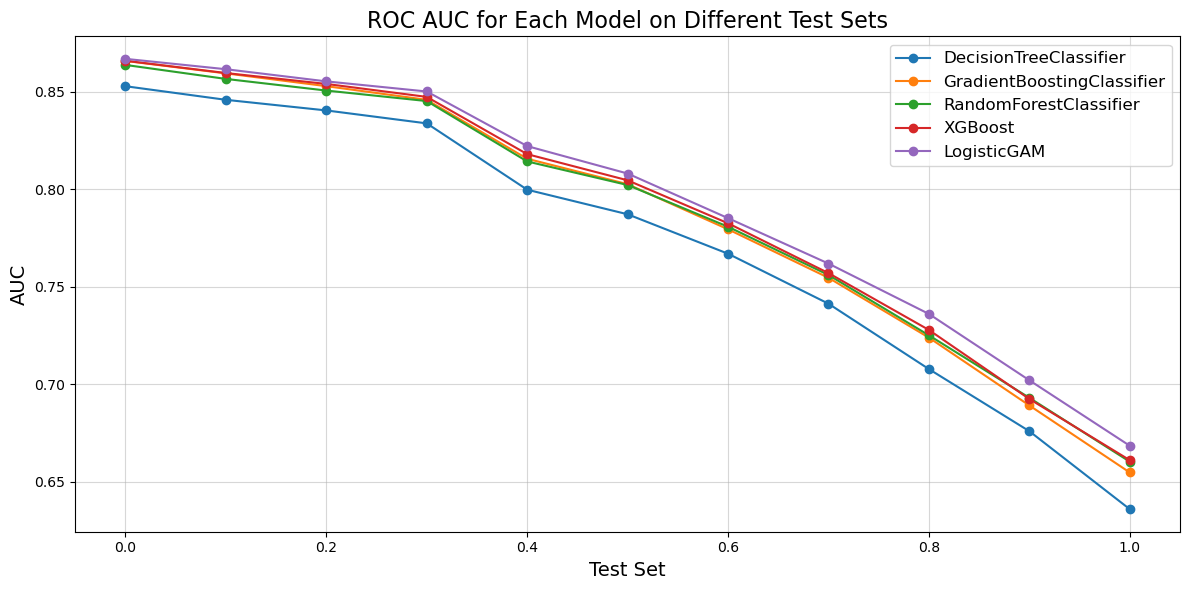

In [26]:
# Assuming df_dict is a dictionary with keys from 0.1 to 1.0
test_datasets = [(key, df.drop(['Y','Z'], axis=1), df['Y']) for key, df in df_dict.items() if 0.0 <= key <= 1.0]

evaluator = ModelEvaluator(models, test_datasets)
evaluator.evaluate_models(show_metrics=False) # = True)
#evaluator.plot_roc_curves()
#evaluator.plot_roc_curves_per_dataset()
evaluator.plot_auc()

 # 5. Mechanistic-Interpretability-Guided Robust Boosting

In [27]:
#from typing import Optional, Tuple, Union
#
#from sklearn.base import BaseEstimator
#from src.robust_training.mechanistic import MechanisticTrainer
#try:
#    from pygam import LogisticGAM
#    PYGAM_AVAILABLE = True
#except ImportError:
#    PYGAM_AVAILABLE = False
#
#
#def run_mechanistic_robust_training_and_eval(
#    folder: str = "dat",
#    target: str = 'Y',
#    n_rounds: int = 2,
#    model_type: str = 'gbc',  # Options: 'gbc', 'tree', 'gam'
#    base_shift_factor: float = 100,
#    fraction_to_shift: float = 0.9,
#    final_train_size: Optional[int] = None,
#    random_state: int = 42,
#    noise_scale: float = 0.001,
#    n_grad_steps: int = 1,
#    top_k: int = 3,
#    eps = 0.2, 
#    ball = False
#) -> Tuple[BaseEstimator, BaseEstimator]:
#    """
#    Trains both a baseline model and a robust model using MechanisticTrainer,
#    then evaluates both models on all shifted test files in the specified folder.
#
#    Parameters
#    ----------
#    folder : str
#        Directory containing 'train.csv' for training and 'mix_<n>.csv' for testing.
#    target : str
#        Name of the target variable in the datasets.
#    n_rounds : int
#        Number of augmentation rounds for MechanisticTrainer.
#    model_type : str
#        Type of model to use for robust training. Options: 'gbc', 'tree', 'gam'.
#    base_shift_factor : float
#        Magnitude by which to shift selected features during augmentation.
#    fraction_to_shift : float
#        Fraction of the dataset to select for augmentation each round.
#    final_train_size : int or None
#        If specified, downsample the final training set to this size.
#    random_state : int
#        Seed for reproducibility.
#    noise_scale : float
#        Standard deviation of Gaussian noise added to augmented samples.
#    n_grad_steps : int
#        Number of gradient-based steps per sample during augmentation.
#    top_k : int
#        Number of top features (by gradient magnitude) to shift per sample.
#
#    Returns
#    -------
#    baseline_model : BaseEstimator
#        The baseline model trained on the original data.
#    robust_model : BaseEstimator
#        The robustly trained model using MechanisticTrainer.
#    """
#
#    # ----------------------------------------------------------------------
#    # 1) Load original training data from "mix_0.0.csv"
#    # ----------------------------------------------------------------------
#    train_file = os.path.join(folder, "train.csv")
#    if not os.path.exists(train_file):
#        raise FileNotFoundError(f"Training file '{train_file}' not found in folder '{folder}'.")
#
#    df_orig = pd.read_csv(train_file)
#    if target not in df_orig.columns:
#        raise ValueError(f"Target column '{target}' not found in '{train_file}'.")
#
#    X_train = df_orig.drop(columns=[target])
#    y_train = df_orig[target]
#
#    print(f"Loaded training data from '{train_file}' with shape = {X_train.shape}")
#
#    # ----------------------------------------------------------------------
#    # 2) Train Baseline Model
#    #    Ensure baseline uses the same model_type for fair comparison.
#    # ----------------------------------------------------------------------
#    print("\n=== Training Baseline Model ===")
#    if model_type == 'gbc':
#        baseline_model = GradientBoostingClassifier(
#            n_estimators=100,
#            learning_rate=0.05,
#            max_depth=4,                        # default 3 ma fa pena, a 10 ha migliore AUC ma comunque minore f1, a 4/5 è fair
#            random_state=random_state
#        )
#    elif model_type == 'tree':
#        baseline_model = DecisionTreeClassifier(
#            max_depth=10,                       # default 5 ma fa pena, a 10 ha peggiore AUC e comunque minore f1 ma è fair
#            random_state=random_state
#        )
#    elif model_type == 'gam':
#        if not PYGAM_AVAILABLE:
#            raise ImportError("pyGAM is not installed. Install it via `pip install pygam` or choose another model type.")
#        baseline_model = LogisticGAM( verbose=False)
#        
#    elif model_type == 'rfc':
#        baseline_model = RandomForestClassifier(
#            n_estimators=100,
#            max_depth=10,                   # default 5 ma fa pena, a 10 ha peggiore AUC e comunque minore f1 ma è fair
#            random_state=random_state
#        )
#    
#    else:
#        raise ValueError(f"Unsupported model_type '{model_type}'. Choose from ['gbc', 'tree', 'gam'].")
#
#    baseline_model.fit(X_train, y_train)
#    
#    print("Baseline model trained.")
#    # Check class distribution in shifted data
#    df_shifted = pd.read_csv('data/mix_1.0.csv')
#    print("Class distribution in shifted data:")
#    print(df_shifted['Y'].value_counts(normalize=True))
#
#    # Check model predictions
#    y_pred = baseline_model.predict(df_shifted.drop('Y', axis=1))
#    print("\nPrediction distribution:")
#    print(pd.Series(y_pred).value_counts(normalize=True))
#    
#
#    # ----------------------------------------------------------------------
#    # 3) Train Mechanistic-Interpretability-Guided Robust Model
#    # ----------------------------------------------------------------------
#    print("\n=== Training Mechanistic-Interpretability-Guided Robust Model ===")
#    trainer = MechanisticTrainer(
#        model_type=model_type,         # 'gbc', 'tree', 'gam'
#        base_shift_factor=base_shift_factor,
#        n_rounds=n_rounds,
#        subset_size_fraction=fraction_to_shift,
#        n_grad_steps=n_grad_steps,
#        top_k=top_k,
#        random_state=random_state,
#        noise_scale=noise_scale,
#       
#        val_fraction=0.1,               # Fraction for validation split
#        eps = eps,
#        ball = ball
#    )
#
#
#
#    # Fit the robust model
#    trainer.fit(X_train, y_train)
#    robust_model = trainer.model
#    print("Robust model trained.")
#
#    # If final_train_size is specified, downsample & refit
#    if final_train_size is not None and final_train_size < len(trainer.X_final):
#        rng = np.random.RandomState(random_state)
#        idx_down = rng.choice(len(trainer.X_final), size=final_train_size, replace=False)
#        X_down = trainer.X_final.iloc[idx_down].reset_index(drop=True)
#        y_down = trainer.y_final.iloc[idx_down].reset_index(drop=True)
#        robust_model.fit(X_down, y_down)
#        print(f"Final training set downsampled to {final_train_size} samples.")
#        # Check class distribution in shifted data
#    df_shifted = pd.read_csv('data/mix_1.0.csv')
#    print("Class distribution in shifted data:")
#    print(df_shifted['Y'].value_counts(normalize=True))
#
#    # Check model predictions
#    y_pred = robust_model.predict(df_shifted.drop('Y', axis=1))
#    print("\nPrediction distribution:")
#    print(pd.Series(y_pred).value_counts(normalize=True))
#
#    # ----------------------------------------------------------------------
#    # 4) Evaluate on all shifted test files: "mix_<n>.csv"
#    # ----------------------------------------------------------------------
#    test_files = [
#        f for f in os.listdir(folder)
#        if f.startswith("mix_") and f.endswith(".csv") 
#    ]
#
#    if not test_files:
#        print(f"\nNo shifted test files found in '{folder}' for evaluation.")
#        return baseline_model, robust_model
#
#    print("\n=== Evaluation on Shifted Test Files ===")
#    for test_file in sorted(test_files):
#        test_path = os.path.join(folder, test_file)
#        df_test = pd.read_csv(test_path)
#        if target not in df_test.columns:
#            print(f"Skipping '{test_file}': missing target '{target}'.")
#            continue
#
#        X_test = df_test.drop(columns=[target])
#        y_test = df_test[target]
#
#        # Evaluate Baseline Model
#        y_pred_b = baseline_model.predict(X_test)
#        if hasattr(baseline_model, "predict_proba"):
#            y_proba_b = baseline_model.predict_proba(X_test)[:, 1]
#            try:
#                auc_b = roc_auc_score(y_test, y_proba_b)
#            except ValueError:
#                auc_b = "N/A (only one class present)"
#        else:
#            y_proba_b = None
#            auc_b = "N/A"
#
#        acc_b = accuracy_score(y_test, y_pred_b)
#        f1_b = f1_score(y_test, y_pred_b) 
#
#        # Evaluate Robust Model
#        y_pred_r = robust_model.predict(X_test)
#        if hasattr(robust_model, "predict_proba"):
#            y_proba_r = robust_model.predict_proba(X_test)[:, 1]
#            try:
#                auc_r = roc_auc_score(y_test, y_proba_r)
#            except ValueError:
#                auc_r = "N/A (only one class present)"
#        else:
#            y_proba_r = None
#            auc_r = "N/A"
#
#        acc_r = accuracy_score(y_test, y_pred_r)
#        f1_r = f1_score(y_test, y_pred_r) 
#        print(f"\nTest File: {test_file}")
#        print(f"  Baseline Model => Accuracy: {acc_b:.3f}, F1 Score: {f1_b:.3f}, AUC: {auc_b}")
#        print(f"  Robust Model   => Accuracy: {acc_r:.3f}, F1 Score: {f1_r:.3f}, AUC: {auc_r}")
#        print("-" * 50)
#
#        print(f"\nTest File: {test_file}: delta AUC r-b (hope > 0): {auc_r - auc_b}")
#
#    return baseline_model, robust_model
#
#

In [28]:
# DATA_FOLDER = 'data'
# TARGET_COLUMN = 'Y'

# # Run the robust training and evaluation
# baseline_model, robust_model = run_mechanistic_robust_training_and_eval(
#     folder=DATA_FOLDER,
#     target=TARGET_COLUMN,
#     n_rounds=1,
#     model_type='rfc',          # Options: 'gbc', 'tree', 'gam', 'rfc'
#     base_shift_factor=3.5,    
#     fraction_to_shift=0.9,
#     final_train_size=None,     # Keep the original size
#     random_state=42,
#     noise_scale=0.01,
#     n_grad_steps=1,
#     top_k=3, 
#     eps=0.2,
#     ball=True
# )


In [29]:
# DATA_FOLDER = 'data'
# TARGET_COLUMN = 'Y'

# for eps in np.arange(0.1, 1.0, 0.1):
#     print(f"###############################Running for epsilon = {eps}")
#     # Run the robust training and evaluation
#     baseline_model, robust_model = run_mechanistic_robust_training_and_eval(
#         folder=DATA_FOLDER,
#         target=TARGET_COLUMN,
#         n_rounds=1,
#         model_type='rfc',          # Options: 'gbc', 'tree', 'gam', 'rfc'
#         base_shift_factor=100,    
#         fraction_to_shift=0.9,
#         final_train_size=1000,     # Keep the original size
#         random_state=42,
#         noise_scale=0.0001,
#         n_grad_steps=5,
#         top_k=3, 
#         eps=eps
#     )